In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Helper functions for visualization.
%matplotlib inline
from IPython.display import HTML
#from IPython.display import Javascript  # Restrict height of output cell.
#display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'''))
display(HTML("<style>.container { width:100% !important; }</style>"))

time_window = 1

# for computing mean
initframe = 100

def moving_average(a, n) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

# Also should work:
#def moving_average(x, w):
#    return np.convolve(x, np.ones(w), 'valid') / w


# Check how to treat bulldozing
class Timers():
    def __init__(self,file):
        
        self.moving_patches = []
        self.ray_testing = []
        self.ray_casting = []
        self.contact_patches = []
        self.pre_nn = []
        self.nn = []
        self.post_nn = []
        #self.post_nn2 = []
        self.contact_forces = []
        self.bulldozing = []
        
        self.nn_time = None
        self.terrain_time = None
        self.tot_time = None
        
        self.integrateY = []
        self.integrateY_adv = []
        
        self.vis = []
        self.sync = []
        self.advance = []
        self.tot = []
        
        self.lastframe = 875#750
        
        
        if "rover" in file:
            self.dt = 5e-4
        else:
            self.dt = 2e-3
            
        self.load_data(file)
        self.title = file[file.find("/out")+1:].replace(".txt","")
        
        self.timesteps = [tim*self.dt for tim in range(len(self.moving_patches))]
        #self.use_moving_average()
        
        self.nn = self.fillzerosarray(self.nn)
        self.pre_nn = self.fillzerosarray(self.pre_nn)
        self.post_nn = self.fillzerosarray(self.post_nn)
        #self.post_nn2 = self.fillzerosarray(self.post_nn2)
        
        self.get_tot_time() 
        
        self.timers = [
        self.moving_patches,
        self.ray_testing,
        self.ray_casting,
        self.contact_patches,
        self.contact_forces,
        self.bulldozing,
            ]
        
        self.tot = np.array(self.tot)
        
    def fillzerosarray(self, timer):
        
        if len(timer)==0:
            timer = len(self.timesteps)*[0]
            
        return timer
            
                
    def get_terrain_time(self):
        
        totsteps = len(self.moving_patches)
            
        self.terrain_time = [self.moving_patches[it] + self.ray_casting[it] + self.contact_patches[it] + self.bulldozing[it] for it in range(totsteps)]
        
        return self.terrain_time
    
    def get_nn_time(self):
        
        totsteps = len(self.moving_patches)
            
        self.nn_time = [self.pre_nn[it] + self.nn[it] + self.post_nn[it] for it in range(totsteps)]
        
        return self.nn_time
    
    def get_tot_time(self):
        
        totsteps = len(self.moving_patches)
        
        if self.terrain_time is None:
            self.get_terrain_time()
            
        if self.nn_time is None:
            self.get_nn_time()
            
        self.tot_time = [self.terrain_time[it] + self.nn_time[it] +  self.contact_forces[it] for it in range(totsteps)]
        
        return self.tot_time
    
    def use_moving_average(self):
        
        self.moving_patches = moving_average(np.array(self.moving_patches),time_window)
        self.ray_testing = moving_average(np.array(self.ray_testing),time_window)
        self.ray_casting = moving_average(np.array(self.ray_casting),time_window)
        self.contact_patches = moving_average(np.array(self.contact_patches),time_window)
        self.contact_forces = moving_average(np.array(self.contact_forces),time_window)
        self.bulldozing = moving_average(np.array(self.bulldozing),time_window)
        
    def plot_times_scm(self):

        timesteps = self.timesteps#[time_window-1:]
        plt.plot(timesteps,self.moving_patches,color="r",label="Moving patches")
        #plt.plot(timesteps,self.ray_testing,color="y",label="ray_testing")
        plt.plot(timesteps,self.ray_casting,color="g",label="Ray casting")
        plt.plot(timesteps,self.contact_patches,color="m",label="Contact Patches")
        #if len(self.nn)>0:
        plt.plot(timesteps,self.pre_nn,color="y",label="Preprocess NN")
        plt.plot(timesteps,self.nn,color="orange",label="Forward NN")
        plt.plot(timesteps,self.post_nn,color="pink",label="Postprocess NN")
        #if len(self.post_nn2)>0:
        #    plt.plot(timesteps,self.post_nn2,color="c",label="Postprocess NN (global hits)")
        plt.plot(timesteps,self.contact_forces,color="b",label="Contact Forces")
        #plt.plot(timesteps,self.bulldozing,color="grey",label="Bulldozing")
        #plt.plot(timesteps,self.get_terrain_time(),color="orange",label="terrain_time")
        plt.plot(timesteps,self.tot_time,color="k",label="Total SCM")
        
        plt.ylabel("Computation time [ms]")
        plt.xlabel("Time [s]")
        #plt.xlim([0.0,timesteps[-1]])
        plt.xlim([0,timesteps[self.lastframe]])
        maxynum = max(self.tot_time[5:self.lastframe])
        plt.ylim([1.e-3,maxynum])
        plt.locator_params(axis="y",nbins=20)
        #plt.yticks(range(0,maxynum,maxynum/20))
        #plt.yscale("log")
        plt.grid()
        plt.legend()
        plt.title(self.title)
        plt.show()
        plt.close()
        
    def plot_times_tot(self):
        
        self.vis = moving_average(np.array(self.vis),time_window)
        self.sync = moving_average(np.array(self.sync),time_window)
        self.advance = moving_average(np.array(self.advance),time_window)
        self.tot = moving_average(np.array(self.tot),time_window)

        #timesteps = self.timesteps#[time_window-1:]
        timesteps = self.timesteps[time_window-1:]
        
        plt.plot(timesteps,self.vis,color="b",label="Visualization")
        plt.plot(timesteps,self.sync,color="r",label="Synchronization")
        plt.plot(timesteps,self.advance,color="g",label="Advance")
        #plt.plot(timesteps,self.integrateY_adv,color="c",label="Integrate Y Advance")
        #plt.plot(timesteps,self.integrateY,color="m",label="Integrate Y")
        plt.plot(timesteps,self.tot,color="k",label="Total")
        
        plt.ylabel("Computation time [ms]")
        plt.xlabel("Time [s]")
        #plt.xlim([0.0,timesteps[-1]])
        plt.xlim([0,timesteps[self.lastframe]])
        maxynum = max(self.tot[5:self.lastframe])
        plt.ylim([1.e-3,maxynum])
        plt.locator_params(axis="y",nbins=20)
        #plt.yscale("log")
        plt.grid()
        plt.legend()
        plt.title(self.title)
        plt.show()
        plt.close()
        
    def mean_times(self):
        
        means = []
        for timer in self.timers:
            means.append(timer[initframe:].mean())
        
        return means
    
    def std_times(self):
        
        stds = []
        for timer in self.timers:
            stds.append(timer[initframe:].std())
        
        return stds
        
    def gettimefromline(self,string,line,timer):
        if line.startswith(string):
            timer.append(float(line.replace(string,"").split()[-1]))
    
    
    def load_data(self, file):
        
        file = open(file, "r").readlines()
        
        for il, line in enumerate(file):
                
            self.gettimefromline("Timer advance integrate Y (ms): ",line,self.integrateY_adv)
            self.gettimefromline("Timer total integrate Y (ms): ",line,self.integrateY)
            
            self.gettimefromline("   Moving patches:",line,self.moving_patches)
            self.gettimefromline("   Ray testing:",line,self.ray_testing)
            self.gettimefromline("   Ray casting:",line,self.ray_casting)
            self.gettimefromline("   Contact patches:",line,self.contact_patches)
            self.gettimefromline("   Preprocess NN:",line,self.pre_nn)
            self.gettimefromline("   Neural Network:",line,self.nn)
            self.gettimefromline("   Postprocess NN:",line,self.post_nn)
            #self.gettimefromline("   Postprocess NN (global hits):",line,self.post_nn2)
            self.gettimefromline("   Contact forces:",line,self.contact_forces)
            self.gettimefromline("   Bulldozing:",line,self.bulldozing)
            
            self.gettimefromline("Visualization time by step (ms): ",line,self.vis)
            self.gettimefromline("Synchronization time by step (ms): ",line,self.sync)
            self.gettimefromline("Advance time by step (ms): ",line,self.advance)
            self.gettimefromline("Total time by step (ms): ",line,self.tot)
            
           


out_polaris_scm


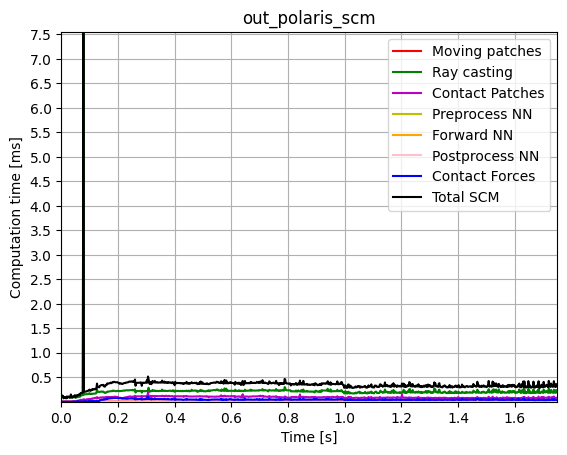

(725,)
out_polaris_nn


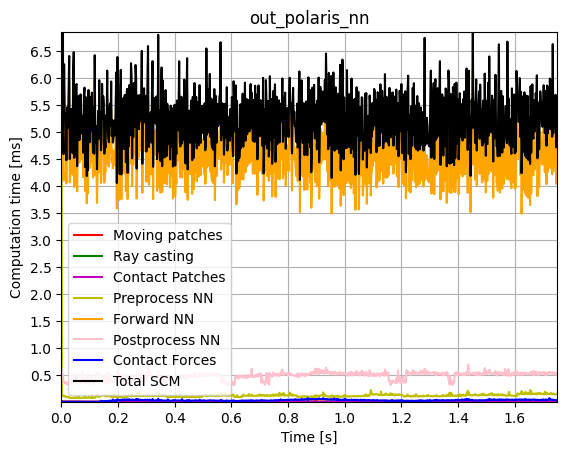

(725,)
out_polaris_multiple_scm


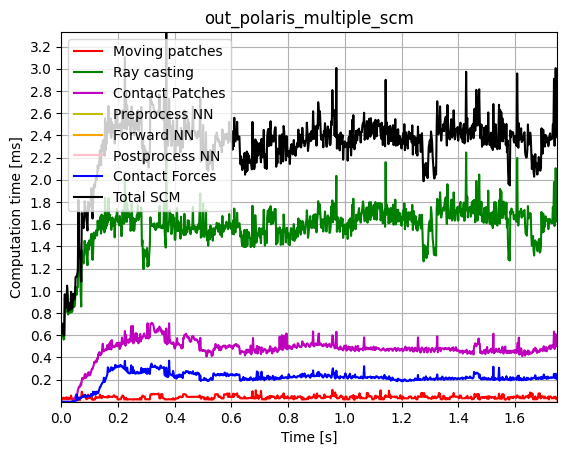

(725,)
out_polaris_multiple_nn


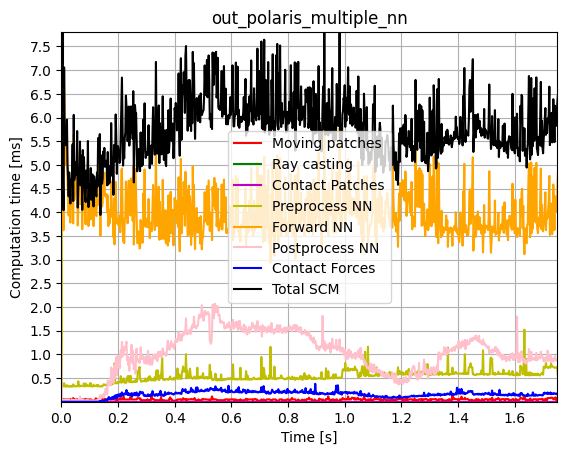

(725,)
out_polaris_rocks_scm


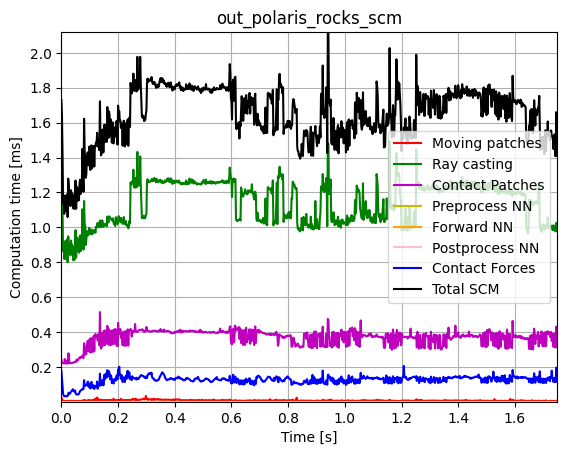

(725,)
out_polaris_rocks_nn


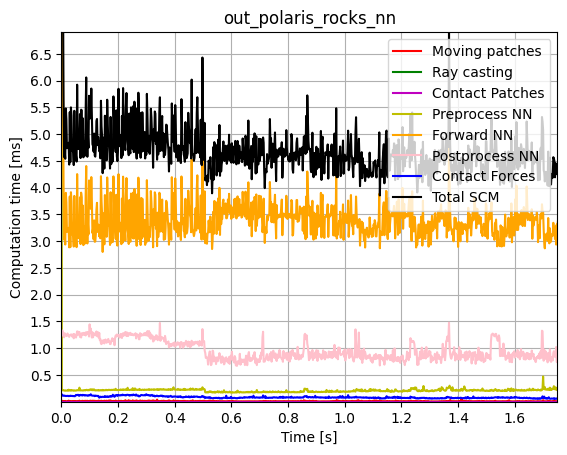

(725,)
out_rover_scm


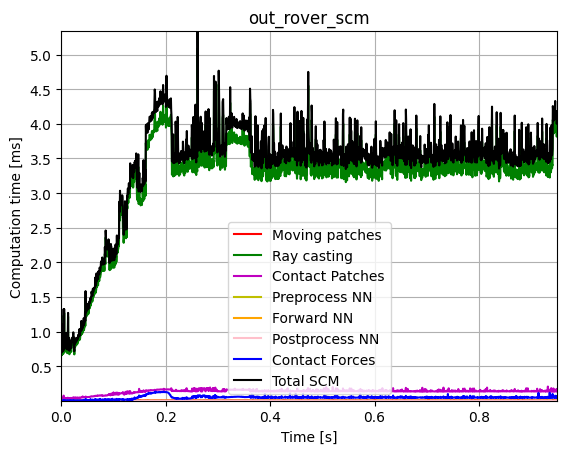

(325,)
out_rover_nn


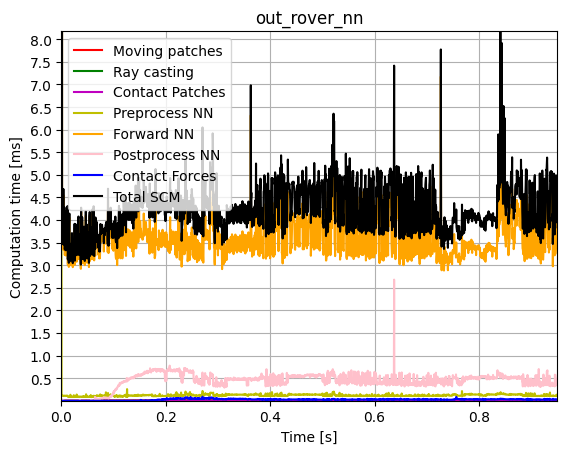

(325,)
out_rover_rocks_scm


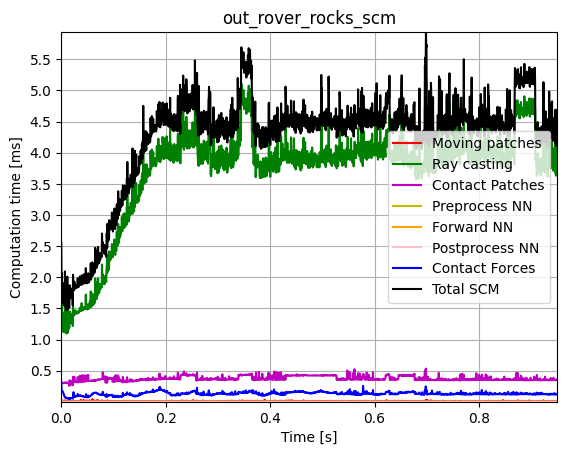

(325,)
out_rover_rocks_nn


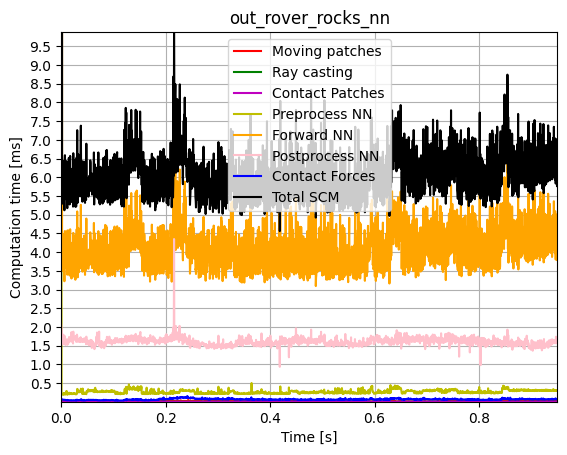

(325,)


In [2]:
#mainpath = "/home/tda/CARLA/chrono_scm_newcode/build_cuda/bin/"
#mainpath = "/home/tda/CARLA/chrono_scm_newcode/scm_analysis/DenizResults/"
mainpath = "/home/tda/CARLA/chrono_scm_newcode/scm_analysis/runs/"

outfiles = [mainpath+"out_polaris_scm.txt",
            mainpath+"out_polaris_nn.txt",
            mainpath+"out_polaris_multiple_scm.txt",
            mainpath+"out_polaris_multiple_nn.txt",
            mainpath+"out_polaris_rocks_scm.txt",
            mainpath+"out_polaris_rocks_nn.txt",
            mainpath+"out_rover_scm.txt",
            mainpath+"out_rover_nn.txt",
            mainpath+"out_rover_rocks_scm.txt",
            mainpath+"out_rover_rocks_nn.txt"
           ]

df = pd.DataFrame()

meanvals, stdvals, titles = [], [], []
for file in outfiles:
    
    timers = Timers(file)
    print(timers.title)
    
    #firstindex = 500 if "polaris" in timers.title else 2000
    firstindex = 150
    #if "rover" in file:
    #    timers.lastframe *= 4
    #    firstindex *= 4
    
    #if "multiple" in timers.title:
    #    timers.lastframe = 750
    
    if "rover" in timers.title:
        #firstindex = 500
        #print(timers.lastframe)
        timers.lastframe = 475*4#-1
        #print(timers.lastframe)

    timers.plot_times_scm()
    #timers.plot_times_tot()
    
    #tottime_pre = timers.advance
    #tottime_pre = timers.tot
    tottime_pre = np.array(timers.tot_time)
    
    #print("we",tottime_pre.shape,firstindex,timers.lastframe,timers.lastframe-firstindex)
    tottime = tottime_pre if "polaris" in timers.title else tottime_pre[::4]
    
    if "rover" in timers.title:
        #firstindex = 500
        #print(timers.lastframe)
        timers.lastframe = 475#-1
        #print(timers.lastframe)
    
    tottime = tottime[firstindex:timers.lastframe]
    print(tottime.shape)
    
    meanvals.append(tottime.mean()); stdvals.append(tottime.std()); titles.append(timers.title)
    
    #df[timers.title] = tottime
    
    #print(timers.mean_times())
    #meanvals.append(timers.mean_times()[2]); stdvals.append(timers.std_times()[2]); titles.append(timers.title)

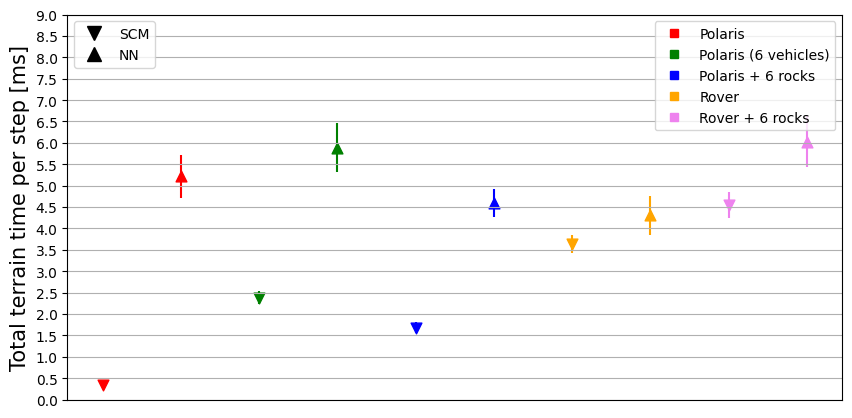

In [3]:
import matplotlib.lines as mlines

colors = ["r","r","g","g","b","b","orange","orange","violet","violet"]

plt.close()
plt.figure(figsize=(10,5))

for i in range(len(meanvals)):

    marker = "^" if "nn" in titles[i] else "v" 
    plt.scatter(i, meanvals[i], marker=marker, color=colors[i], s=60)
    plt.vlines(x=i, ymin=meanvals[i]-stdvals[i], ymax=meanvals[i]+stdvals[i], color=colors[i], zorder=1.e-1)

    
customlegend1 = []
customlegend1.append( mlines.Line2D([], [], color='k', marker='v', linestyle='None', markersize=10, label='SCM') )
customlegend1.append( mlines.Line2D([], [], color='k', marker='^', linestyle='None', markersize=10, label='NN') )
legend1 = plt.legend(handles=customlegend1, loc="upper left")

customlegend2 = []
customlegend2.append( mlines.Line2D([], [], color='red', marker='s', linestyle='None', label='Polaris') )
customlegend2.append( mlines.Line2D([], [], color='g', marker='s', linestyle='None', label='Polaris (6 vehicles)') )
customlegend2.append( mlines.Line2D([], [], color='b', marker='s', linestyle='None', label='Polaris + 6 rocks') )
customlegend2.append( mlines.Line2D([], [], color='orange', marker='s', linestyle='None', label='Rover') )
customlegend2.append( mlines.Line2D([], [], color='violet', marker='s', linestyle='None', label='Rover + 6 rocks') )

plt.legend(handles=customlegend2, loc="upper right")
plt.gca().add_artist(legend1)

plt.xticks([])
maxlimy = 9
plt.yticks(np.linspace(0,maxlimy,num=maxlimy*2+1))
plt.ylim([0,maxlimy])
plt.grid()
#plt.ylabel("Raycasting computation time per step [ms]")
plt.ylabel("Total terrain time per step [ms]",fontsize=15)
plt.show()

In [4]:
"""
plt.figure(figsize=(14,7))
sns.violinplot(data=df, gridsize=200, scale="width", inner="box")
#sns.boxplot(data=df)
#sns.swarmplot(data=df)
#plt.yscale("log")
#maxlim = 50
plt.yticks(range(0,maxlimy,int(maxlimy/10)))
plt.grid()
plt.ylim([0,maxlimy])
"""

'\nplt.figure(figsize=(14,7))\nsns.violinplot(data=df, gridsize=200, scale="width", inner="box")\n#sns.boxplot(data=df)\n#sns.swarmplot(data=df)\n#plt.yscale("log")\n#maxlim = 50\nplt.yticks(range(0,maxlimy,int(maxlimy/10)))\nplt.grid()\nplt.ylim([0,maxlimy])\n'

Text(0, 0.5, 'NN time per step [ms]')

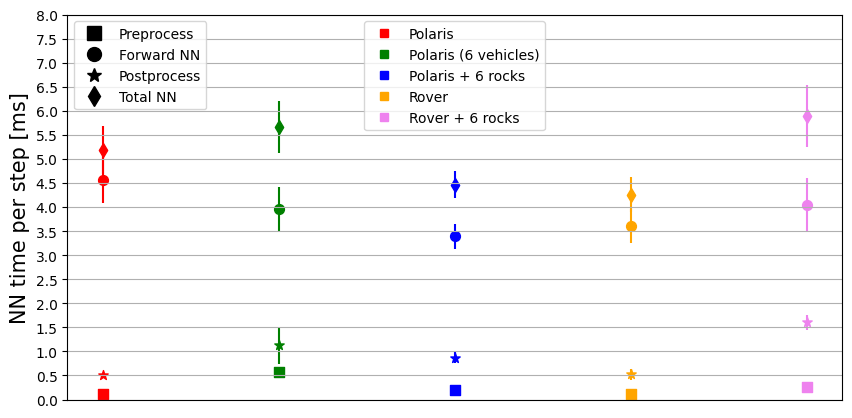

In [5]:
plt.close()
plt.figure(figsize=(10,5))

markers = ["s","o","*","d"]

colors = ["r","g","b","orange","violet"]

outfiles = [
            mainpath+"out_polaris_nn.txt",
            mainpath+"out_polaris_multiple_nn.txt",
            mainpath+"out_polaris_rocks_nn.txt",
            mainpath+"out_rover_nn.txt",
            mainpath+"out_rover_rocks_nn.txt"
           ]

df = pd.DataFrame()

meanvals, stdvals, titles = [], [], []

for i, file in enumerate(outfiles):
    
    timers = Timers(file)
    #print(timers.title)
    
    firstindex = 250
    
    t_pre = np.array(timers.pre_nn[firstindex:timers.lastframe])
    t_nn = np.array(timers.nn[firstindex:timers.lastframe])
    t_post = np.array(timers.post_nn[firstindex:timers.lastframe])
    t_tot = t_pre + t_nn + t_post
    
    plt.scatter([], [], marker=".", color=colors[i], s=50)#, label=timers.title)
    
    #"""
    for j, t in enumerate([t_pre, t_nn, t_post, t_tot]):
        
        mean, std = t.mean(), t.std()
    
        plt.scatter(i, mean, marker=markers[j], color=colors[i], s=50)
        plt.vlines(x=i, ymin=mean-std, ymax=mean+std, color=colors[i], zorder=1.e-1)
    """
    
    t = (t_pre + t_post)/t_nn
    mean, std = t.mean(), t.std()
    plt.scatter(i, mean, marker=markers[j], color=colors[i], s=50)
    plt.vlines(x=i, ymin=mean-std, ymax=mean+std, color=colors[i], zorder=1.e-1)
    #"""
        

customlegend1 = []
customlegend1.append( mlines.Line2D([], [], color='k', marker='s', linestyle='None', markersize=10, label='Preprocess') )
customlegend1.append( mlines.Line2D([], [], color='k', marker='o', linestyle='None', markersize=10, label='Forward NN') )
customlegend1.append( mlines.Line2D([], [], color='k', marker='*', linestyle='None', markersize=10, label='Postprocess') )
customlegend1.append( mlines.Line2D([], [], color='k', marker='d', linestyle='None', markersize=10, label='Total NN') )
legend1 = plt.legend(handles=customlegend1, loc="upper left")

customlegend2 = []
customlegend2.append( mlines.Line2D([], [], color='red', marker='s', linestyle='None', label='Polaris') )
customlegend2.append( mlines.Line2D([], [], color='g', marker='s', linestyle='None', label='Polaris (6 vehicles)') )
customlegend2.append( mlines.Line2D([], [], color='b', marker='s', linestyle='None', label='Polaris + 6 rocks') )
customlegend2.append( mlines.Line2D([], [], color='orange', marker='s', linestyle='None', label='Rover') )
customlegend2.append( mlines.Line2D([], [], color='violet', marker='s', linestyle='None', label='Rover + 6 rocks') )

plt.legend(handles=customlegend2, loc="upper center")
plt.gca().add_artist(legend1)
        
plt.xticks([])
#"""
maxlimy = 8
plt.yticks(np.linspace(0,maxlimy,num=maxlimy*2+1))
plt.ylim([0,maxlimy])
#"""
plt.grid()
plt.ylabel("NN time per step [ms]",fontsize=15)
